In [1]:
import pandas as pd
import json
import time
import geopandas as gpd
%pylab inline
import fiona
from shapely.geometry import Point, Polygon, shape, box
import glob

Populating the interactive namespace from numpy and matplotlib


In [2]:
from pyproj import Proj, transform

inProj = Proj(init='epsg:3857')
outProj = Proj(init='epsg:4326')

In [3]:
import contextily as ctx

#original function (plot with epsg:3857)
def add_basemap(ax, zoom,url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))

In [4]:
#custom function (plot with epsg:4326)
def add_basemap_crs4326(ax, zoom, bounds_crs3857, url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):
    xmin, ymin, xmax, ymax = bounds_crs3857
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    
    minx, maxx, miny, maxy = extent
    new_boundary = []
    for point in [(minx,miny), (maxx,miny), (maxx, maxy), (minx, maxy)]:
        x,y = point
        lon,lat = transform(inProj,outProj,x,y)
        new_boundary.append((lon,lat))
        
    lon_min, lat_min, lon_max, lat_max = Polygon(new_boundary).bounds
    new_extent = (lon_min, lon_max, lat_min, lat_max)
    ax.imshow(basemap, extent=new_extent, interpolation='bilinear', aspect='equal')
    ax.axis(new_extent)

# ATLANTA 

In [5]:
df_city_zips = pd.read_csv('data/atlanta/median_income_city.csv')

In [6]:
# Import atlanta geometry
df_atlanta_geo = gpd.read_file('data/atlanta/median_household_income.geojson')
df_atlanta_geo = df_atlanta_geo[df_atlanta_geo.geoid.map(len)==12].iloc[1:].reset_index(drop=True)
df_atlanta_geo['name'] = df_atlanta_geo['name'].astype(int)

df_atlanta_geo = df_atlanta_geo[df_atlanta_geo.name.isin(df_city_zips.name.iloc[1:].astype(int))]

df_atlanta_geo['geog'] = 1
atlanta_bounds_3857 = tuple(df_atlanta_geo.dissolve(by='geog').to_crs(epsg=3857).bounds.iloc[0])
lon_min, lat_min, lon_max, lat_max = tuple(df_atlanta_geo.dissolve(by='geog').bounds.iloc[0])

df_atlanta_geo.head() 

geoid   name  B19013001  B19013001, Error  \
17  86000US30030  30030    77789.0            5197.0   
18  86000US30032  30032    36660.0            1555.0   
19  86000US30033  30033    67462.0            5421.0   
49  86000US30080  30080    65159.0            2613.0   
50  86000US30082  30082    74180.0            3729.0   

                                             geometry  geog  
17  (POLYGON ((-84.275881 33.789941, -84.275779 33...     1  
18  (POLYGON ((-84.319642 33.724184, -84.319624 33...     1  
19  (POLYGON ((-84.32241999999999 33.804055, -84.3...     1  
49  (POLYGON ((-84.54209299999999 33.893592, -84.5...     1  
50  (POLYGON ((-84.490413 33.820468, -84.490393999...     1

[]

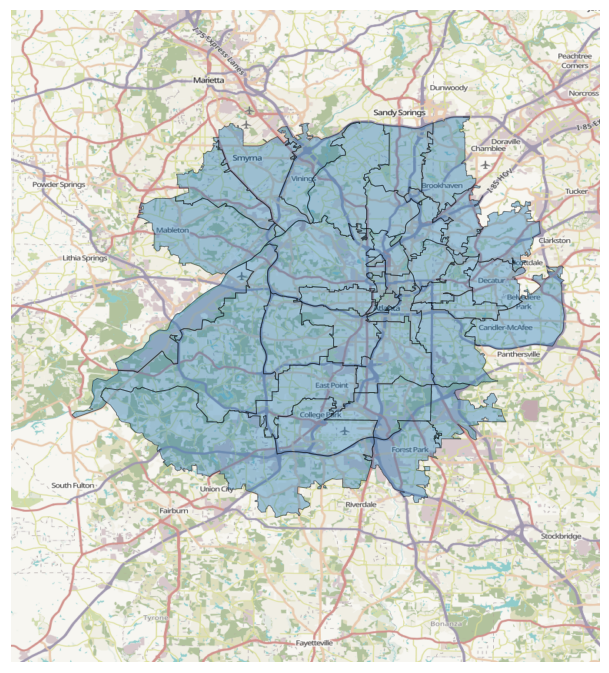

In [7]:
ax = df_atlanta_geo[df_atlanta_geo.name.isin(df_city_zips.name.iloc[1:].astype(int))].geometry.plot(figsize=(12, 12), alpha=0.40, edgecolor='k')
add_basemap_crs4326(ax, zoom=11, bounds_crs3857=atlanta_bounds_3857, url='https://a.tile.openstreetmap.fr/hot/tileZ/tileX/tileY.png')
# ax.set_xlim([lon_min, lon_max])
# ax.set_ylim([lat_min, lat_max])
ax.set_axis_off()
ax.set_xticks([])
ax.set_yticks([])

# BOGOTA

In [8]:
# Import Bogotà geometry
df_bogota_geo = gpd.read_file('data/bogota/bogota_zat_info.geojson').dissolve('upz_id')

df_bogota_geo.head()

geometry    x_coord  \
upz_id                                                                 
1       POLYGON ((-74.031116 4.769412, -74.031183 4.76... -74.036631   
2       POLYGON ((-74.063849 4.772318, -74.06384 4.772... -74.052473   
3       POLYGON ((-74.038217 4.799344, -74.038501 4.79... -74.045132   
9       POLYGON ((-74.02464000000001 4.756132, -74.025... -74.035295   
10      POLYGON ((-74.03172499999999 4.742823, -74.031... -74.022023   

         y_coord  zat_id                   upz_name local_name  local_id  \
upz_id                                                                     
1       4.796238     959  PASEO DE LOS LIBERTADORES    USAQUEN         1   
2       4.774961       8                LA ACADEMIA       SUBA        11   
3       4.817580     960                  GUAYMARAL       SUBA        11   
9       4.768271     956                   VERBENAL    USAQUEN         1   
10      4.749473      20                   LA URIBE    USAQUEN         1   

        population  median_income  
upz_id                             
1                0              0  
2                0              0  
3            24896              6  
9                0              0  
10               0              0

In [9]:
# Import Bogotà Grid geometry
df_bogota_grid = gpd.read_file('data/bogota/bogota_circles_radius1km.geojson')

df_bogota_grid['geog'] = 1
bogota_bounds_3857 = tuple(df_bogota_grid.dissolve(by='geog').to_crs(epsg=3857).bounds.iloc[0])
lon_min, lat_min, lon_max, lat_max = tuple(df_bogota_grid.dissolve(by='geog').bounds.iloc[0])

print(df_bogota_grid.shape)
df_bogota_grid.head()

(196, 5)


id     lat      lon                                           geometry  geog
0  0  4.4541 -74.1454  POLYGON ((-74.13638516716217 4.4541, -74.13642...     1
1  1  4.4701 -74.1544  POLYGON ((-74.14538516716217 4.4701, -74.14542...     1
2  2  4.4861 -74.1454  POLYGON ((-74.13638516716217 4.4861, -74.13642...     1
3  3  4.5021 -74.1544  POLYGON ((-74.14538516716217 4.5021, -74.14542...     1
4  4  4.5181 -74.1454  POLYGON ((-74.13638516716217 4.5181, -74.13642...     1

[]

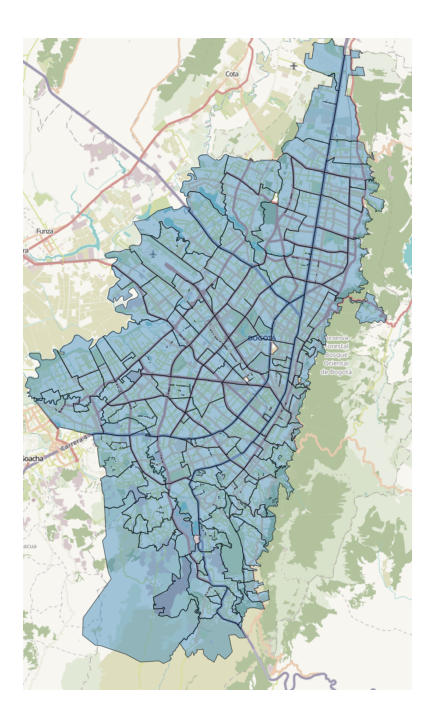

In [10]:
ax = df_bogota_geo.geometry.plot(figsize=(12, 12), alpha=0.40, edgecolor='k')
add_basemap_crs4326(ax, zoom=12, bounds_crs3857=bogota_bounds_3857, url='https://a.tile.openstreetmap.fr/hot/tileZ/tileX/tileY.png')
ax.set_xlim([lon_min, lon_max])
ax.set_ylim([lat_min, lat_max])
ax.set_axis_off()
ax.set_xticks([])
ax.set_yticks([])

[]

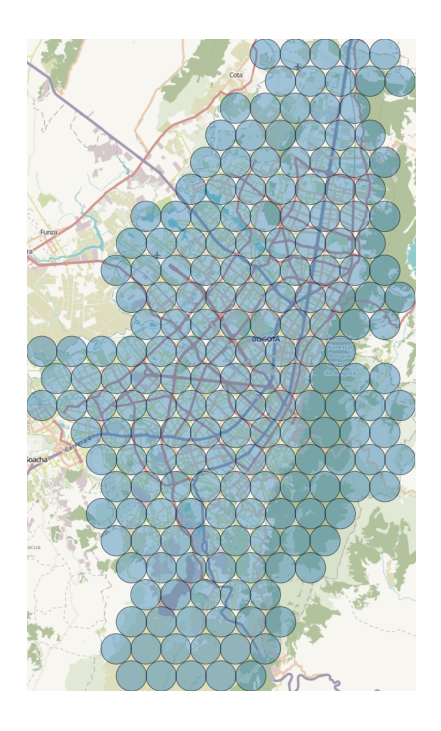

In [11]:
ax = df_bogota_grid.geometry.plot(figsize=(12, 12), alpha=0.40, edgecolor='k')
add_basemap_crs4326(ax, zoom=12, bounds_crs3857=bogota_bounds_3857, url='https://a.tile.openstreetmap.fr/hot/tileZ/tileX/tileY.png')
ax.set_xlim([lon_min, lon_max])
ax.set_ylim([lat_min, lat_max])
ax.set_axis_off()
ax.set_xticks([])
ax.set_yticks([])

# SANTIAGO

In [12]:
# Import Santiago Grid geometry
df_santiago_grid = gpd.read_file('data/santiago/santiago_circles_radius1km.geojson')

df_santiago_grid['geog'] = 1
santiago_bounds_3857 = tuple(df_santiago_grid.dissolve(by='geog').to_crs(epsg=3857).bounds.iloc[0])
# lon_min, lat_min, lon_max, lat_max = tuple(df_santiago_grid.dissolve(by='geog').bounds.iloc[0])

print(df_santiago_grid.shape)
df_santiago_grid.head()

(324, 5)


lat        lon id                                           geometry  \
0 -33.62 -70.791017  0  POLYGON ((-70.78112241551085 -33.62, -70.78117...   
1 -33.62 -70.772193  1  POLYGON ((-70.76229888609909 -33.62, -70.76234...   
2 -33.62 -70.753370  2  POLYGON ((-70.74347535668733 -33.62, -70.74352...   
3 -33.62 -70.734546  3  POLYGON ((-70.72465182727555 -33.62, -70.72469...   
4 -33.62 -70.715723  4  POLYGON ((-70.70582829786379 -33.62, -70.70587...   

   geog  
0     1  
1     1  
2     1  
3     1  
4     1

In [13]:
# Import Santiago geometry
df_santiago_geo = gpd.read_file('data/santiago/comunas.geojson')
df_santiago_geo=df_santiago_geo[df_santiago_geo.province=='Santiago']

df_santiago_geo.head()

id  province                            region   code         comuna  \
2  2  Santiago  Región Metropolitana de Santiago  13108  Independencia   
3  3  Santiago  Región Metropolitana de Santiago  13110     La Florida   
4  4  Santiago  Región Metropolitana de Santiago  13115   Lo Barnechea   
5  5  Santiago  Región Metropolitana de Santiago  13116      Lo Espejo   
6  6  Santiago  Región Metropolitana de Santiago  13117       Lo Prado   

                                            geometry  
2  POLYGON ((-70.65730231541191 -33.4047855561251...  
3  POLYGON ((-70.43946260195784 -33.4920620816643...  
4  POLYGON ((-70.4772351326163 -33.3695027096448,...  
5  POLYGON ((-70.69410527396845 -33.5024321434213...  
6  POLYGON ((-70.70558600981761 -33.4571600757529...

[]

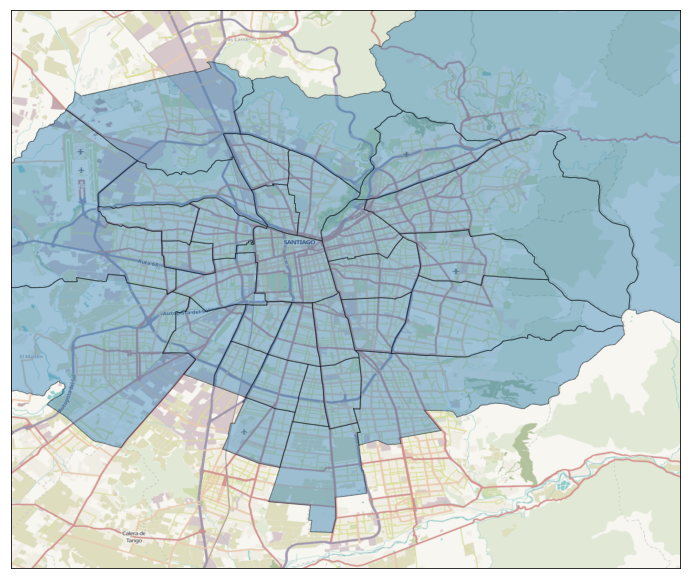

In [14]:
ax = df_santiago_geo.geometry.plot(figsize=(12, 12), alpha=0.40, edgecolor='k')
add_basemap_crs4326(ax, zoom=12, bounds_crs3857=santiago_bounds_3857, url='https://a.tile.openstreetmap.fr/hot/tileZ/tileX/tileY.png')
# ax.set_xlim([lon_min, lon_max])
# ax.set_ylim([lat_min, lat_max])
# ax.set_axis_off()
ax.set_xticks([])
ax.set_yticks([])

[]

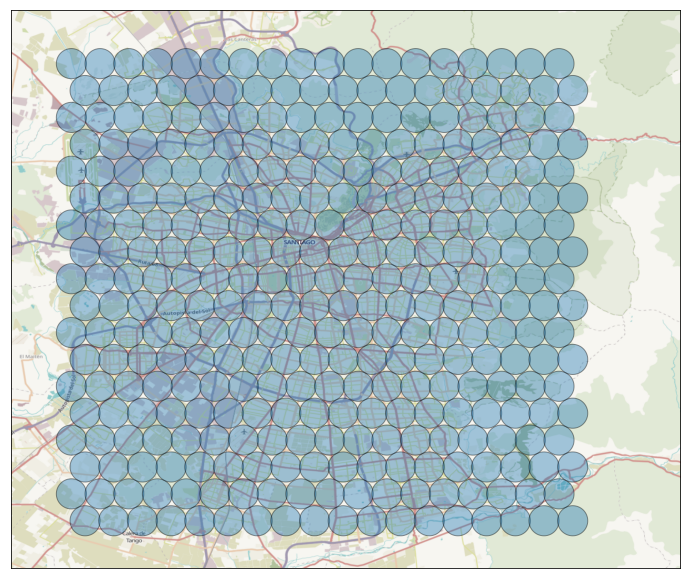

In [15]:
ax = df_santiago_grid.geometry.plot(figsize=(12, 12), alpha=0.40, edgecolor='k')
add_basemap_crs4326(ax, zoom=12, bounds_crs3857=santiago_bounds_3857, url='https://a.tile.openstreetmap.fr/hot/tileZ/tileX/tileY.png')
# ax.set_xlim([lon_min, lon_max])
# ax.set_ylim([lat_min, lat_max])
# ax.set_axis_off()
ax.set_xticks([])
ax.set_yticks([])

# Casablanca

In [16]:
# Import Santiago geometry
df_casablanca_geo = gpd.read_file('data/casablanca/df_final_casablanca.geojson')
df_casablanca_geo.head()

id      ENGTYPE_4  ID_0  ID_1   ID_2   ID_3   ID_4  ISO  \
0  175  Urban Commune   138  1749  20079  38424  20960  MAR   
1  176  Urban Commune   138  1749  20079  38425  20961  MAR   
2  177  Urban Commune   138  1749  20079  38426  20962  MAR   
3  179  Urban Commune   138  1749  20079  38428  20964  MAR   
4  180  Urban Commune   138  1749  20079  38429  20965  MAR   

   Indice_de_pauvretmultidimensionnelle2014  \
0                                  0.231872   
1                                  0.173813   
2                                  0.394835   
3                                  0.226743   
4                                  0.335722   

   Intensit_de_privation_des_pauvres2014  \
0                              35.955776   
1                              35.120094   
2                              35.712654   
3                              36.191814   
4                              35.361950   

                         ...                         REMARKS_4 Shape_Area  \
0                        ...                              None   0.001761   
1                        ...                              None   0.000840   
2                        ...                              None   0.000332   
3                        ...                              None   0.001239   
4                        ...                              None   0.001490   

  Shape_Leng           TYPE_4 Taux_de_pauvretglobale2014   \
0   0.232886  Commune Urbaine                    1.171000   
1   0.194542  Commune Urbaine                    0.931807   
2   0.075307  Commune Urbaine                    3.263527   
3   0.164429  Commune Urbaine                    0.756655   
4   0.158937  Commune Urbaine                    1.747365   

  Taux_de_pauvretmultidimensionnelle2014  VALIDFR_4  VALIDTO_4 VARNAME_4  \
0                               0.644881    Unknown    Present      None   
1                               0.494912    Unknown    Present      None   
2                               1.105589    Unknown    Present      None   
3                               0.626505    Unknown    Present      None   
4                               0.949389    Unknown    Present      None   

                                            geometry  
0  POLYGON ((-7.709583999999893 33.57439099999996...  
1  POLYGON ((-7.598193999999978 33.60180700000001...  
2  POLYGON ((-7.576105999999982 33.53470600000003...  
3  POLYGON ((-7.614081999999996 33.57264200000003...  
4  POLYGON ((-7.649629000000004 33.569053, -7.643...  

[5 rows x 25 columns]

In [17]:
# Import casablanca Grid geometry
df_casablanca_grid = gpd.read_file('data/casablanca/casablanca_circles_radius1km.geojson')

df_casablanca_grid['geog'] = 1
casablanca_bounds_3857 = tuple(df_casablanca_grid.dissolve(by='geog').to_crs(epsg=3857).bounds.iloc[0])
# lon_min, lat_min, lon_max, lat_max = tuple(df_casablanca_grid.dissolve(by='geog').bounds.iloc[0])

print(df_casablanca_grid.shape)
df_casablanca_grid.head()

(104, 5)


lat       lon id                                           geometry  \
0  33.511767 -7.700601  0  POLYGON ((-7.690699985438612 33.51176700000002...   
1  33.511767 -7.680917  1  POLYGON ((-7.671015735438619 33.51176700000002...   
2  33.511767 -7.661232  2  POLYGON ((-7.651331485438627 33.51176700000002...   
3  33.511767 -7.641548  3  POLYGON ((-7.631647235438634 33.51176700000002...   
4  33.511767 -7.621864  4  POLYGON ((-7.611962985438641 33.51176700000002...   

   geog  
0     1  
1     1  
2     1  
3     1  
4     1

[]

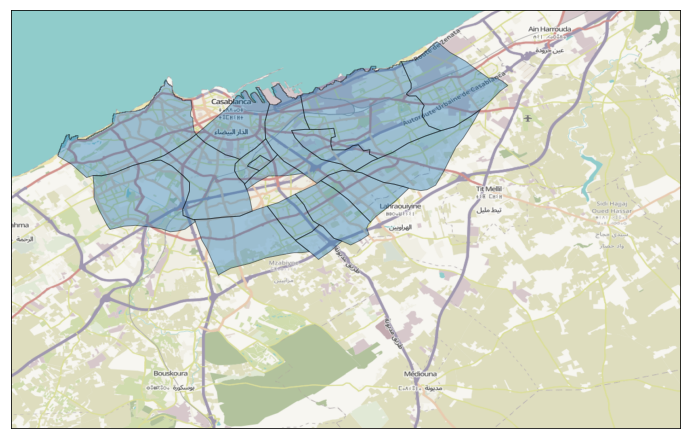

In [18]:
ax = df_casablanca_geo.geometry.plot(figsize=(12, 12), alpha=0.40, edgecolor='k')
add_basemap_crs4326(ax, zoom=12, bounds_crs3857=casablanca_bounds_3857, url='https://b.tile.openstreetmap.fr/hot/tileZ/tileX/tileY.png')
# ax.set_xlim([lon_min, lon_max])
# ax.set_ylim([lat_min, lat_max])
# ax.set_axis_off()
ax.set_xticks([])
ax.set_yticks([])

[]

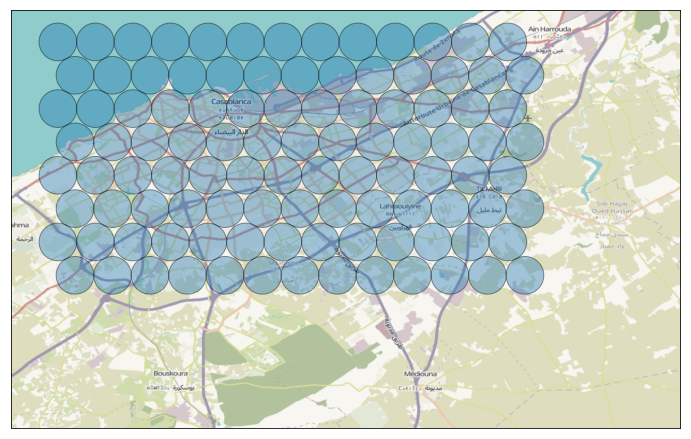

In [19]:
ax = df_casablanca_grid.geometry.plot(figsize=(12, 12), alpha=0.40, edgecolor='k')
add_basemap_crs4326(ax, zoom=12, bounds_crs3857=casablanca_bounds_3857, url='https://b.tile.openstreetmap.fr/hot/tileZ/tileX/tileY.png')
# ax.set_xlim([lon_min, lon_max])
# ax.set_ylim([lat_min, lat_max])
# ax.set_axis_off()
ax.set_xticks([])
ax.set_yticks([])

# PANELS

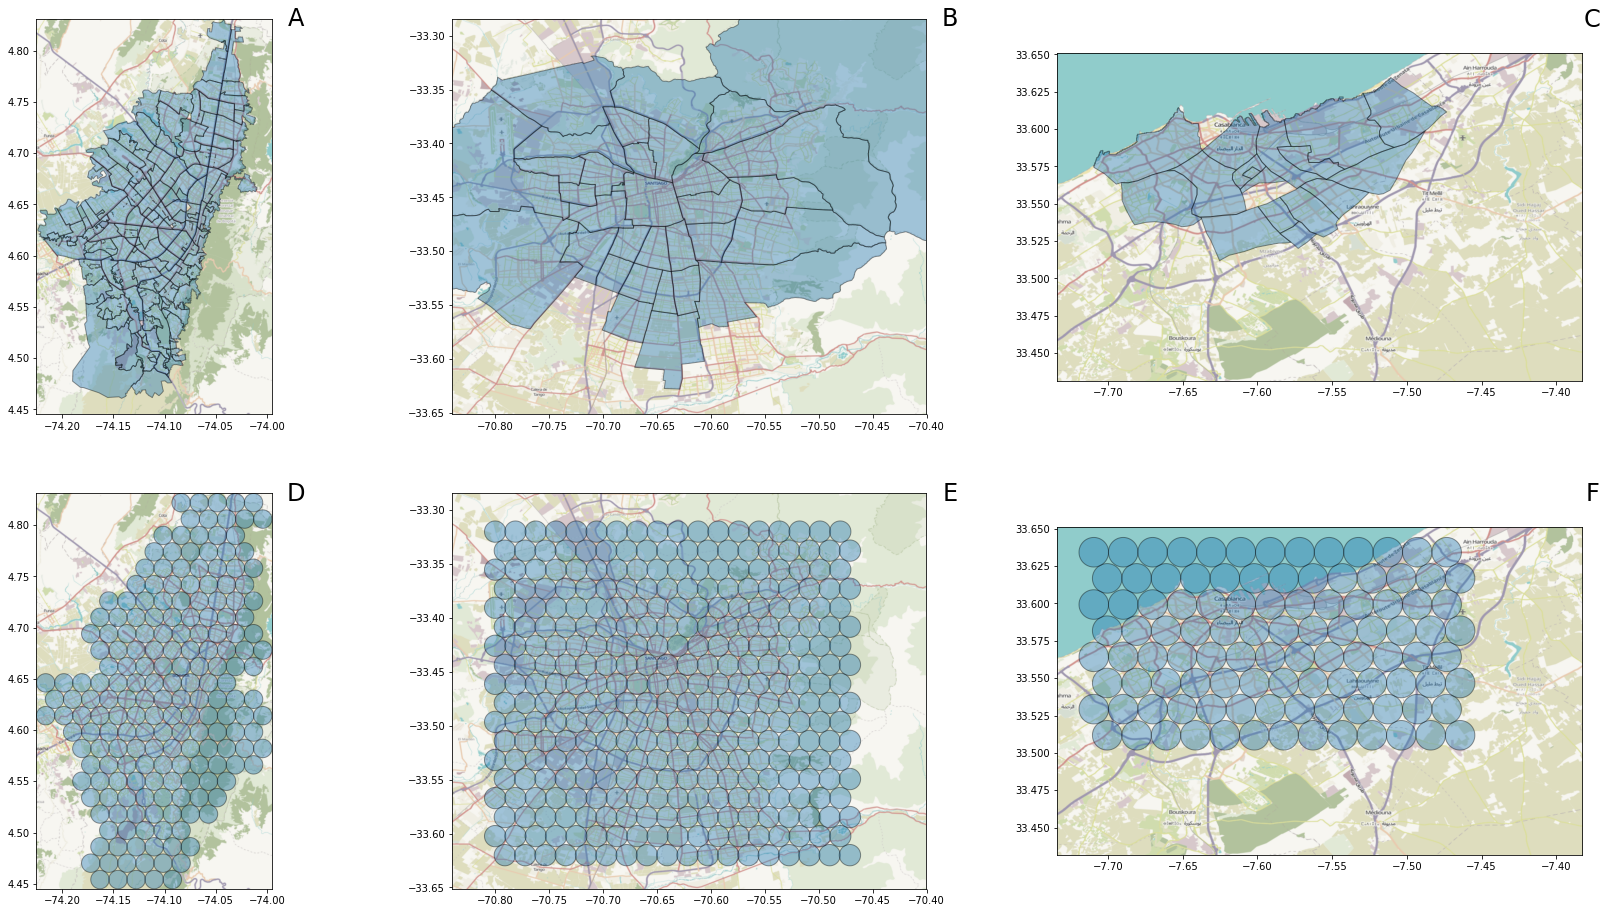

In [23]:
fig, ax = plt.subplots(2,3, figsize=(32,16))

df_bogota_geo.geometry.plot(figsize=(10, 10), alpha=0.40, edgecolor='k', ax=ax[0,0])
add_basemap_crs4326(ax[0,0], zoom=12, bounds_crs3857=bogota_bounds_3857, url='https://a.tile.openstreetmap.fr/hot/tileZ/tileX/tileY.png')
ax[0,0].set_xlim([lon_min, lon_max])
ax[0,0].set_ylim([lat_min, lat_max])
# ax[0,0].set_xticks([])
# ax[0,0].set_yticks([])
# ax[0,0].set_axis_off()
p = ax[0,0].get_position().get_points()
x0, y0 = p[0]
x1, y1 = p[1]
ax[0,0].set_position([x0, y0, 1.3*(x1+x0)/2, y1-y0])
ax[0,0].text(1.1, 1, 'A', fontsize=24, horizontalalignment='center',
        verticalalignment='center', transform=ax[0,0].transAxes)

df_santiago_geo.geometry.plot(figsize=(10, 10), alpha=0.40, edgecolor='k', ax=ax[0,1])
add_basemap_crs4326(ax[0,1], zoom=12, bounds_crs3857=santiago_bounds_3857, url='https://a.tile.openstreetmap.fr/hot/tileZ/tileX/tileY.png')
# ax[0,1].set_xticks([])
# ax[0,1].set_yticks([])
# ax[0,1].set_axis_off()
ax[0,1].text(1.05, 1, 'B', fontsize=24, horizontalalignment='center',
        verticalalignment='center', transform=ax[0,1].transAxes)

df_casablanca_geo.geometry.plot(figsize=(10, 10), alpha=0.40, edgecolor='k', ax=ax[0,2])
add_basemap_crs4326(ax[0,2], zoom=12, bounds_crs3857=casablanca_bounds_3857, url='https://a.tile.openstreetmap.fr/hot/tileZ/tileX/tileY.png')
# ax[0,2].set_xticks([])
# ax[0,2].set_yticks([])
# ax[0,2].set_axis_off()
ax[0,2].text(1.02, 1.1, 'C', fontsize=24, horizontalalignment='center',
        verticalalignment='center', transform=ax[0,2].transAxes)

df_bogota_grid.geometry.plot(figsize=(10, 10), alpha=0.40, edgecolor='k', ax=ax[1,0])
add_basemap_crs4326(ax[1,0], zoom=12, bounds_crs3857=bogota_bounds_3857, url='https://a.tile.openstreetmap.fr/hot/tileZ/tileX/tileY.png')
ax[1,0].set_xlim([lon_min, lon_max])
ax[1,0].set_ylim([lat_min, lat_max])
# ax[1,0].set_xticks([])
# ax[1,0].set_yticks([])
# ax[1,0].set_axis_off()
p = ax[1,0].get_position().get_points()
x0, y0 = p[0]
x1, y1 = p[1]
ax[1,0].set_position([x0, y0, 1.3*(x1+x0)/2, y1-y0])
ax[1,0].text(1.1, 1, 'D', fontsize=24, horizontalalignment='center',
        verticalalignment='center', transform=ax[1,0].transAxes)

df_santiago_grid.geometry.plot(figsize=(10, 10), alpha=0.40, edgecolor='k', ax=ax[1,1])
add_basemap_crs4326(ax[1,1], zoom=12, bounds_crs3857=santiago_bounds_3857, url='https://a.tile.openstreetmap.fr/hot/tileZ/tileX/tileY.png')
# ax[1,1].set_xticks([])
# ax[1,1].set_yticks([])
# ax[1,1].set_axis_off()
ax[1,1].text(1.05, 1, 'E', fontsize=24, horizontalalignment='center',
        verticalalignment='center', transform=ax[1,1].transAxes)

df_casablanca_grid.geometry.plot(figsize=(10, 10), alpha=0.40, edgecolor='k', ax=ax[1,2])
add_basemap_crs4326(ax[1,2], zoom=12, bounds_crs3857=casablanca_bounds_3857, url='https://a.tile.openstreetmap.fr/hot/tileZ/tileX/tileY.png')
# ax[1,2].set_xticks([])
# ax[1,2].set_yticks([])
# ax[1,2].set_axis_off()
ax[1,2].text(1.02, 1.1, 'F', fontsize=24, horizontalalignment='center',
        verticalalignment='center', transform=ax[1,2].transAxes)
plt.savefig('figures/Fig2_city_circles.pdf', dpi=150, bbox_inches='tight')
# plt.savefig('figures/Fig2_city_circles.png', dpi=150, bbox_inches='tight')